In [1]:
import datetime
import os
import time
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import helpers
import warnings
warnings.filterwarnings("ignore")

In [2]:
def download_data(verbose=True):
	"""
	Fetching the data from public servers

	Parameters
	----------
	verbose: boolean

	Returns
	-------
	trips: list of dicts
        Each distionary has a 'dep' and 'arr' key, indicating the
        departure and arrival date-times for each trip
	"""
	#Harvard Square. Red - line stop. Outbound
	hardvard_stop_id = '70068'
	#JFK/UMass. Red - line stop. Inbound
	jfk_stop_id = '70086'

	#gather trip data
	#assuming that we want to reach Harvard Sq at 9 am
	#we consider a safe margin around it
	start_time = datetime.time(7,0)
	end_time = datetime.time(10,0)
	start_date = datetime.date(2015,5,1) #May 2015
	end_date = datetime.date(2018,5,1) #May 2018

	#Constructing URL Partwise
	#Refer : https://cdn.mbta.com/sites/default/files/developers/2018-10-30-mbta-realtime-performance-api-documentation-version-0-9-5-public.pdf

	base_ = "http://realtime.mbta.com/developer/api/v2.1/traveltimes"
	apikey_ = "?api_key=wX9NwuHnZU2ToO7GmGR9uw"
	format_ = "&format=json"
	from_stop_ = "&from_stop=" + str(jfk_stop_id)
	to_stop_ = "&to_stop=" + str(hardvard_stop_id)
	
	#Cycle through all days
	dayi = 0
	trips = []
	while True:
		check_date = start_date + datetime.timedelta(days=dayi)
		if(check_date > end_date):
			break
		#Build the query
		temp_from_time = datetime.datetime.combine(check_date, start_time)
		temp_to_time = datetime.datetime.combine(check_date, end_time)
		from_datetime = "&from_datetime=" + str(int(temp_from_time.timestamp()))
		to_datetime = "&to_datetime=" + str(int(temp_to_time.timestamp()))

		SRequest = "".join([
			base_,
			apikey_,
			format_,
			from_stop_,
			to_stop_,
			from_datetime,
			to_datetime
			])
		response = requests.get(SRequest)
		response_json = response.json()
		for trip in response_json['travel_times']:
			trips.append({
				'dep':datetime.datetime.fromtimestamp(float(trip["dep_dt"])),
				'arr':datetime.datetime.fromtimestamp(float(trip["arr_dt"]))
			})
		if verbose:
			print(check_date,':',len(response_json["travel_times"]), " trips")
		dayi += 1
	return trips

In [3]:
def calculate_arrival_times(trips, harvard_walk=4, jfk_walk=6, target_hour=9, target_minute=0, train_dep_min=-60, train_dep_max=0, debug=False):
    """
    Based on the downloaded trips data, calculate the arrival times
    that each possible departure time would result in.
    The kwargs above default to our specific use case (work starts
    at 9:00, it takes 6 minutes to walk to JFK, and it takes
    4 minutes to walk from Harvard Square to work)
    Parameters
    ----------
    harvard_walk, jfk_walk: int
        The time in minutes it takes to make these walks.
    trips: DataFrame
    target_hour, target_minute: int
        The time work starts is target_hour:target_minute.
    train_dep_min, train_dep_max: int
        The time, relative to the target, in minutes when the train departs
        from JFK. Negative number means minutes **before** the target.
        Min and max define the time window under consideration.
    debug: boolean
    """
    minutes_per_hour = 60
    date_format = '%Y-%m-%d'
    trips_expanded = []
    for raw_trip in trips:
        rel_dep = (
            minutes_per_hour * (raw_trip['dep'].hour - target_hour) +
            (raw_trip['dep'].minute - target_minute))
        rel_arr = (
            minutes_per_hour * (raw_trip['arr'].hour - target_hour) +
            (raw_trip['arr'].minute - target_minute))

        if rel_dep > train_dep_min and rel_dep <= train_dep_max:
            new_trip = {
                'departure': rel_dep,
                'arrival': rel_arr,
                'date': raw_trip['dep'].date(),
            }
            trips_expanded.append(new_trip)

    trips_df = pd.DataFrame(trips_expanded)
    if(debug):
        print(trips_df.columns)
        helpers.custom_scatter_plot(trips_df.departure, trips_df.arrival)
        return trips_df
    
    #Calculating possible arrival times
    door_arrivals={}
    for day in trips_df.loc[:,'date'].unique():
        datestr = day.strftime(date_format)
        trips_today = trips_df.loc[trips_df.loc[:, 'date'] == day, :]
        door_arrival = np.zeros(train_dep_max - train_dep_min)
        for i_row, door_departure in enumerate(
                np.arange(train_dep_min, train_dep_max)):
            # Find the next train departure time.
            station_arrival = door_departure + jfk_walk
            try:

                idx = trips_today.loc[
                    trips_today.loc[:, 'departure'] >=
                    station_arrival, 'departure'].idxmin()
                door_arrival[i_row] = (
                    trips_today.loc[idx, 'arrival'] + harvard_walk)
            except Exception:
                # Fill with not-a-numbers (NaN)
                door_arrival[i_row] = np.nan

        door_arrivals[datestr] = pd.Series(
            door_arrival, index=np.arange(train_dep_min, train_dep_max))
    arrival_times_df = pd.DataFrame(door_arrivals) #make the dataframe of door arrival times
    return arrival_times_df

In [4]:
def load_data(file_name = './dataset.pkl'):
    """
    Try to load the dataset from the local system
    Otherwise download it and save it as pickle
    """
    
    try:
        trips = list(pd.read_pickle(file_name))
    except Exception:
        print("Dataset Not Found In Current Working Directory...\nPress ENTER To Start Downloading Now...")
        nothing = input('')
        trips = download_data()
        dataset = pd.Series(trips)
        dataset.to_pickle(file_name)
    return trips

In [5]:
def load_arrival_times(trips, file_name = './arrival_times.pkl'):
    """
    Try to load the dataframe from the local system
    Otherwise re-create it and save it as pickle
    """

    try:
        arrival_df = helpers.restore(file_name)
    except Exception:
        print("Dataframe Not Found In Current Working Directory...\nRecalculating..\n")
        arrival_df = calculate_arrival_times(trips)
        helpers.store(arrival_df, file_name)
        print("Data Saved !")
    return arrival_df

In [6]:
def one_hot_encoder(size, index):
    """
    Simple one hot encoding mechanism function
    
    Params
    ------
    size: size/length of the vector
    index: the index (zero based) which is 1, others are 0 automatically
    
    Returns
    -------
    onehotvector: list
    """
    onehotvector = np.zeros(size)
    onehotvector[index] = 1
    return onehotvector

In [7]:
def create_features(datestrs):
    """
    Find features associated with weekday or not, and season of the year
    
    Params
    ------
    datestrs: list of str
            where each item is a date string of the format YYYY-MM-DD
    Returns
    -------
    features: pandas dataframe
            where each row corresponds to one date with index as the date string
    """
    date_format = '%Y-%m-%d'
    feature_data = []
    
    for row in datestrs:
        current_date = datetime.datetime.strptime(row, date_format).date()
        current_weekday = current_date.weekday()
        current_month = current_date.month-1 #one based to zero based
        current_season = None
        if(current_month <= 2):
            current_season = 0
        elif(current_month <= 5):
            current_season = 1
        elif(current_month <= 8):
            current_season = 2
        elif(current_month <= 11):
            current_season = 3
        else:
            current_season = 0
        #one hot encodings
        day_of_week = one_hot_encoder(7, current_weekday)
        month_of_year = one_hot_encoder(12, current_month)
        season = one_hot_encoder(4, current_season)
        
        #defining the feature set for the following datestring (day)
        feature_set = {
            'Saturday': day_of_week[5],
            'Sunday': day_of_week[6],
            'winter': season[0],
            'spring': season[1],
            'summer': season[2],
            'autumn': season[3],
        }
        feature_data.append(feature_set)
        
    features = pd.DataFrame(data=feature_data, index=datestrs) #pandas data frame of features to return
    return features

In [43]:
def evaluate(tree, arrivals_df, debug=False, debug_plot=False):
    """
    Compare the empirical best departure time for each day
    with the models estimate.
    
    Parameters
    ----------
    tree: DecisionTree object
        The model against which to compare
    arrivals_df: DataFrame
        The empirical dataset against which to compare
    debug: boolean (default=False)
        Print details of all the data points.
    debug_plot: boolean (default=False)
        Plots a scatter plot of day number against minutes late to work.
    Returns
    -------
    mean_absolute_error: float
        The number of minutes between the optimal departure and the time
        recommended by the model. This is a measure of error.
    """
    datestrs = list(arrivals_df.columns)
    features = create_features(datestrs)
    deviation = []
    for datestr in datestrs:
        pred_departure = tree.estimate(features.loc[datestr, :])
        lateness = arrivals_df.loc[:, datestr]
        try:
            deviation.append(lateness.loc[pred_departure])
        except:
            continue
        if(debug):
            print(datestr, 'estimated =', pred_departure, "deviation =", deviation[-1])
    if(debug_plot):
        #making a scatter plot
        plt.plot(deviation, linestyle='none', marker='.')
        plt.xlabel('Day Count')
        plt.ylabel('Minutes Late')
        plt.show()
    return np.mean(deviation)

Index(['arrival', 'date', 'departure'], dtype='object')


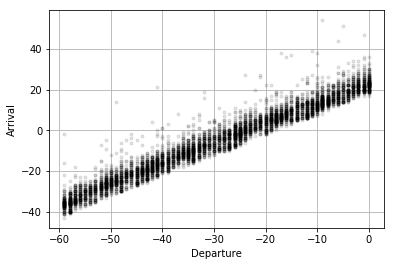

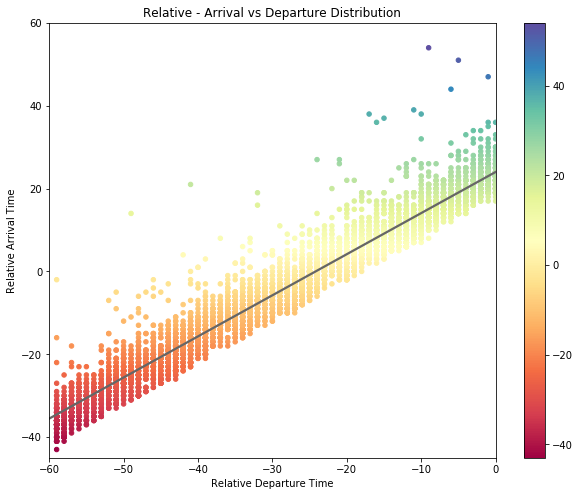

In [9]:
df = calculate_arrival_times(trips, debug=True)

# Graphs are generated from dataframe, when debug=True
#EDA

plt.figure(figsize=(10,8))
points = plt.scatter(df.departure, df.arrival,c=df.arrival, s=20, cmap="Spectral")
plt.colorbar(points)
#set limits
plt.ylim(-45, 60)
plt.xlim(-60, 0)

#build the plot
plot = sb.regplot("departure", "arrival", data=df, scatter=False, color=".4")
plot = plot.set(title='Relative - Arrival vs Departure Distribution', ylabel='Relative Arrival Time', xlabel='Relative Departure Time')

> This clearly shows that although there are a few outliers, most of the trains departing JFK/UMass around 8:30 to 8:40 AM reached Harvard Square at 9 AM (target time).
>
> There is a strong correlation in the data, and the outliers lie only on one side of the line (which is very practical and expected), thus asymmetric distribution.

In [10]:
#Creating features and feature engineering
"""
The day of the week might have some impact on the travelling time and delay.
Whether it is a weekday or a weekend, basically this give the model some extra features to learn from.
Also, we try to figure out the season of the year : winter, spring, summer, etc.
There can be other features too such as day of the week, month of the year and so on. But excess we will stick with the first two.
"""
features = create_features(list(arrival_times_df.columns))
features.head()

,Saturday,Sunday,autumn,spring,summer,winter
2015-05-01,0.0,0.0,0.0,1.0,0.0,0.0
2015-05-02,1.0,0.0,0.0,1.0,0.0,0.0
2015-05-03,0.0,1.0,0.0,1.0,0.0,0.0
2015-05-04,0.0,0.0,0.0,1.0,0.0,0.0
2015-05-05,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
arrival_times_df.fillna(value=30, inplace=True) #Insted of NaN values we replace with an arbitrary value 30
# It denotes that the train arrives at 9:30, this just keeps everything in terms of numbers - thus homogenius dataset

In [12]:
arrival_times_df.tail(10)

,2015-05-01,2015-05-02,2015-05-03,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-09,2015-05-10,...,2018-04-18,2018-04-19,2018-04-20,2018-04-23,2018-04-24,2018-04-25,2018-04-26,2018-04-27,2018-04-30,2018-05-01
-10,30.0,30.0,30.0,30.0,26.0,31.0,26.0,25.0,30.0,30.0,...,30.0,31.0,23.0,30.0,30.0,25.0,31.0,27.0,30.0,30.0
-9,30.0,30.0,30.0,30.0,26.0,31.0,26.0,25.0,30.0,30.0,...,30.0,31.0,30.0,30.0,30.0,25.0,31.0,27.0,30.0,30.0
-8,30.0,30.0,30.0,30.0,26.0,31.0,26.0,25.0,30.0,30.0,...,30.0,31.0,30.0,30.0,30.0,25.0,31.0,27.0,30.0,30.0
-7,30.0,30.0,30.0,30.0,26.0,31.0,26.0,25.0,30.0,30.0,...,30.0,30.0,30.0,30.0,30.0,30.0,31.0,27.0,30.0,30.0
-6,30.0,30.0,30.0,30.0,26.0,31.0,30.0,25.0,30.0,30.0,...,30.0,30.0,30.0,30.0,30.0,30.0,31.0,30.0,30.0,30.0
-5,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
-4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
-3,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
-2,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
-1,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0


In [14]:
# manual splitting the dataset
training_dates, testing_dates = [], []
last_training_day = datetime.datetime.strptime('2016-04-30','%Y-%m-%d') #cut off date
for datestr in arrival_times_df.columns:
    this_date = datetime.datetime.strptime(datestr,'%Y-%m-%d')
    if(this_date <= last_training_day):
        training_dates.append(datestr)
    else:
        testing_dates.append(datestr)
        
        
#making dataframes for train and test
train_df = arrival_times_df.loc[:,training_dates]
test_df = arrival_times_df.loc[:,testing_dates]

In [16]:
from decision_tree import DecisionTree
from judge import Judge
#judge = Judge(arrival_times_df)
tree = DecisionTree(err_fn=judge.find_total_absolute_deviation)
#tree.fit(features)
#tree.render()

In [17]:
training_features = create_features(list(train_df.columns))
judge = Judge(train_df)
tree.fit(training_features)

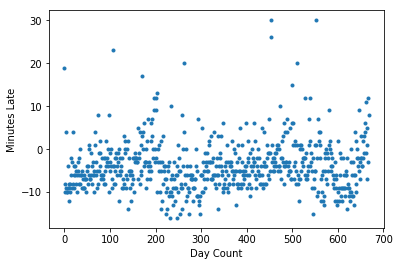

Testing Score:  -3.8370702541106128


In [25]:
#model performance evaluation
testing_score = evaluate(tree, test_df,debug=False,debug_plot=True)
print("Testing Score: ",testing_score)

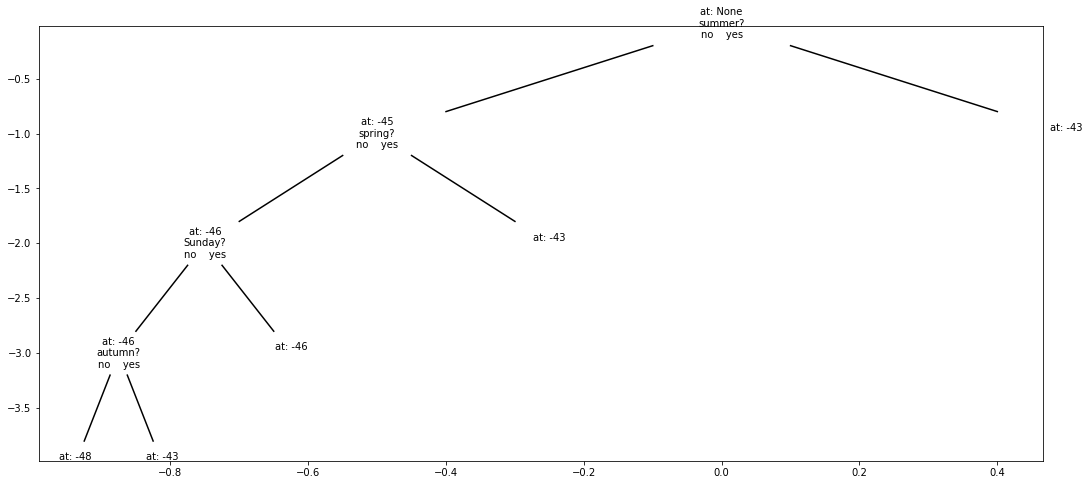

In [26]:
tree.render()

In [44]:
def create_tree(verbose=False):
    """
    Parameters
    ----------
    verbose: boolean
    Returns
    -------
    tree: DecisionTree
    """
    # Load the data.
    trips = load_data() #loads data
    arrival_times_df = load_arrival_times(trips)

    # Assume nan means that the train is late.
    arrival_times_df.fillna(value=30, inplace=True)

    # Split the data into training and testing sets.
    training_dates = []
    tuning_dates = []
    testing_dates = []

    last_training_day = datetime.datetime.strptime('2016-04-30', '%Y-%m-%d')
    last_tuning_day = datetime.datetime.strptime('2017-04-30', '%Y-%m-%d')

    for datestr in arrival_times_df.columns:
        this_date = datetime.datetime.strptime(datestr, '%Y-%m-%d')
        if this_date <= last_training_day:
            training_dates.append(datestr)
        if this_date <= last_tuning_day:
            tuning_dates.append(datestr)
        else:
            testing_dates.append(datestr)

    training_df = arrival_times_df.loc[:, training_dates]
    tuning_df = arrival_times_df.loc[:, tuning_dates]
    testing_df = arrival_times_df.loc[:, testing_dates]

    training_features_df = create_features(list(training_df.columns))
    judge = Judge(training_df)

    # Tune our hyperparameter.
    # Iterate over values for n_min.
    best_tuning_score = 1e10
    best_n_min = 0
    best_tree = None
    for n_min in range(10, 100, 10):

        tree = DecisionTree(
            err_fn=judge.find_total_absolute_deviation, n_min=n_min)
        tree.fit(training_features_df)
        training_score = evaluate(tree, training_df)
        tuning_score = evaluate(tree, tuning_df)

        if tuning_score < best_tuning_score:
            best_tuning_score = tuning_score
            best_n_min = n_min
            best_tree = tree

        if verbose:
            print('n_min', n_min)
            print('training', training_score)
            print('tuning', tuning_score)
            tree.render()

    testing_score = evaluate(best_tree, testing_df)
    
    if verbose:
        print('best_n_min', best_n_min)
        print('best_tuning', best_tuning_score)
        print('testing score', testing_score)

    return best_tree

In [45]:
def recommend(datestrs, name='departure_tree',verbose=True):
    """
    Parameters
    ----------
    datestrs: list of strings
        Datestrings of the format YYYY-MM-DD
    name: string
        Stem of the file name where model is store
    verbose: boolena  (default=True)
    
    Returns
    -------
    recommendation: dict of int
    """
    model_name = './' + name + '.pkl'
    try:
        tree = helpers.restore(model_name)
    except:
        tree = create_tree(verbose=verbose)
        helpers.store(tree, './'+model_name)
    features_df = create_features(datestrs)
    departures = {}
    for datestr in datestrs:
        estimated_dep = tree.estimate(features_df.loc[datestr, :])
        departures[datestr] = estimated_dep
    return departures

n_min 10
training -6.188953488372093
tuning -5.527326440177252


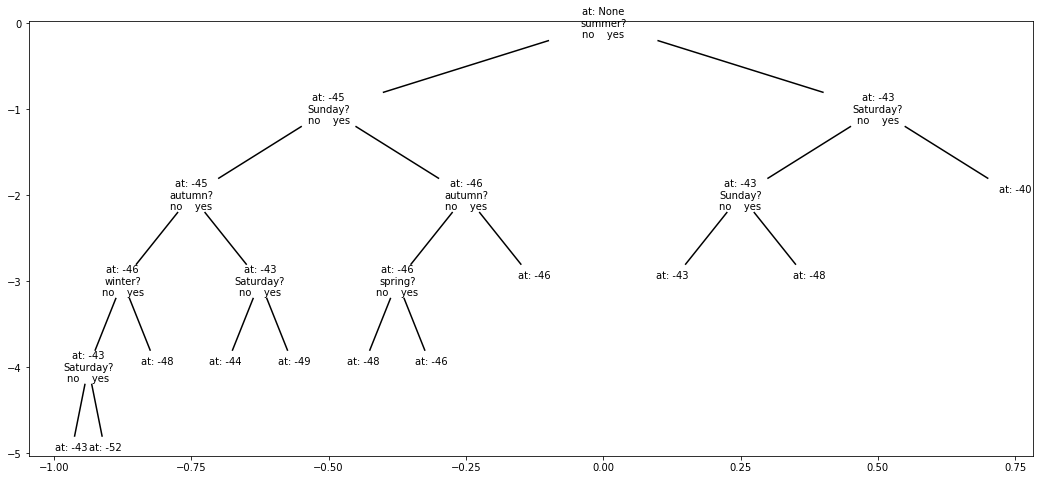

n_min 20
training -5.703488372093023
tuning -5.10930576070901


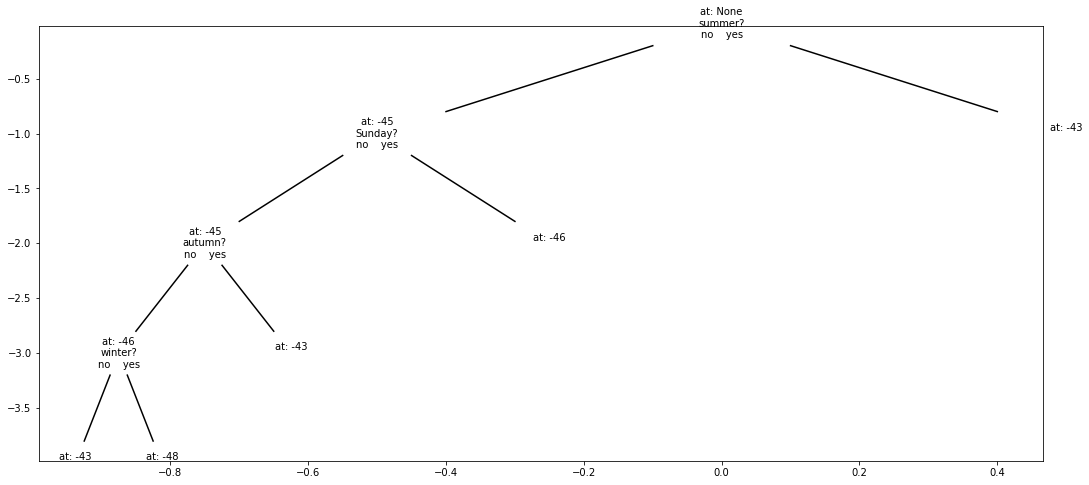

n_min 30
training -5.703488372093023
tuning -5.10930576070901


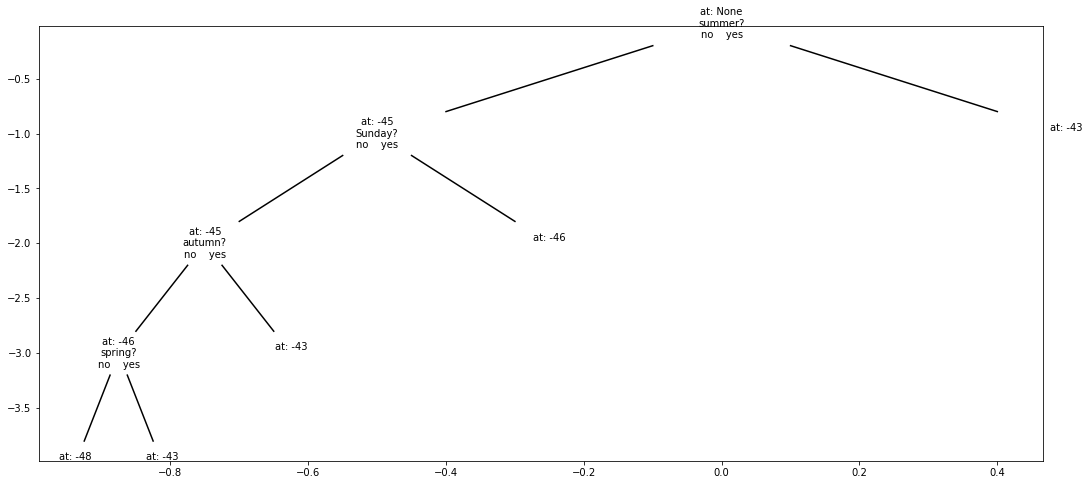

n_min 40
training -5.808139534883721
tuning -5.174298375184638


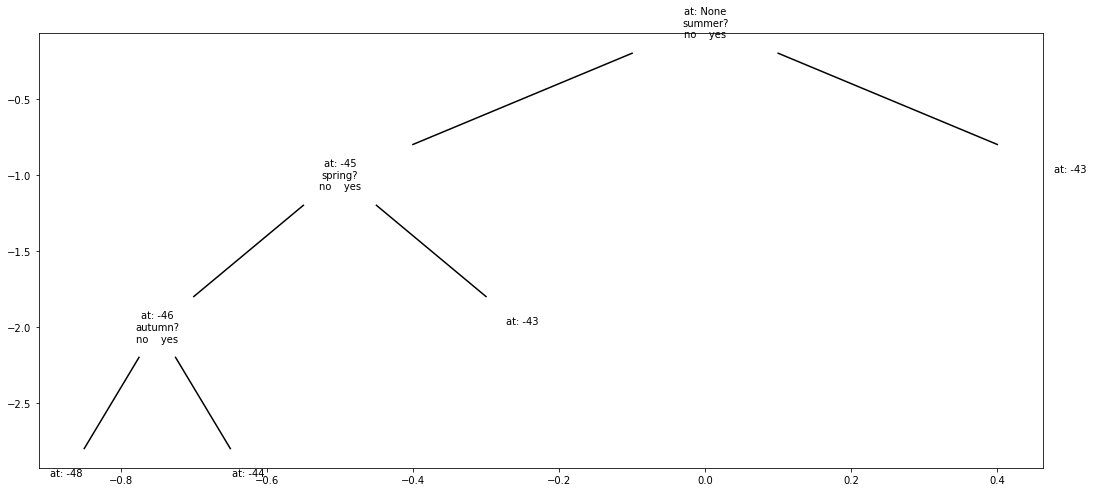

n_min 50
training -5.808139534883721
tuning -5.174298375184638


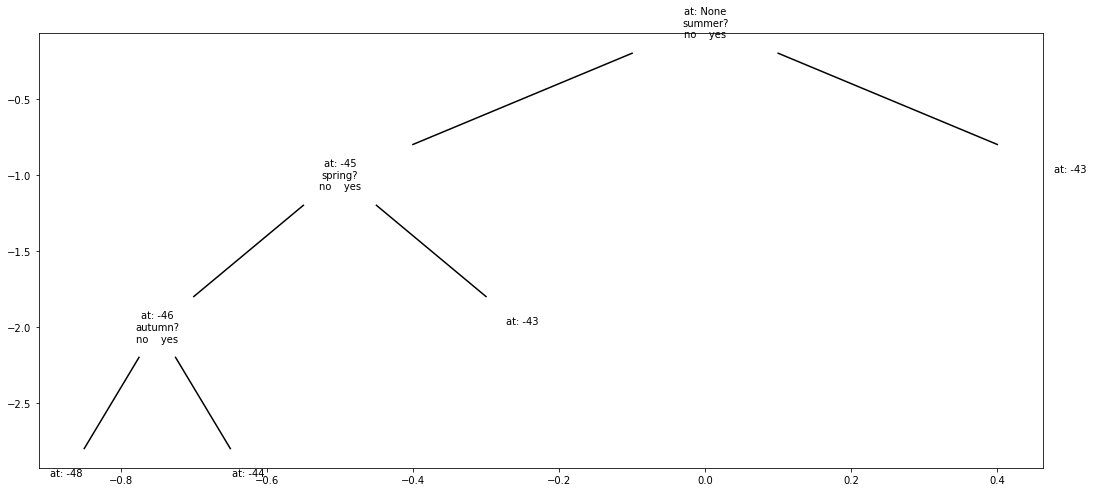

n_min 60
training -5.808139534883721
tuning -5.174298375184638


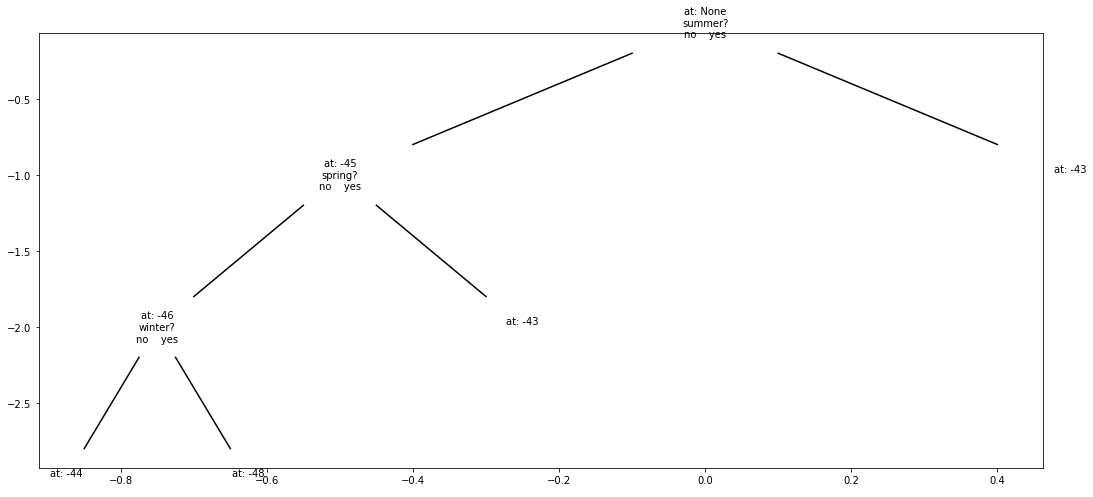

n_min 70
training -5.808139534883721
tuning -5.174298375184638


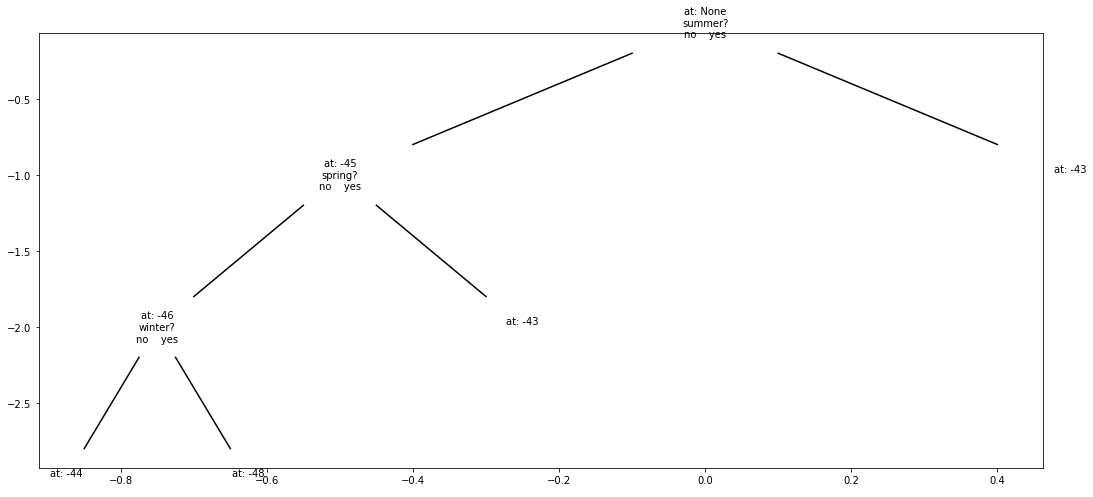

n_min 80
training -5.808139534883721
tuning -5.174298375184638


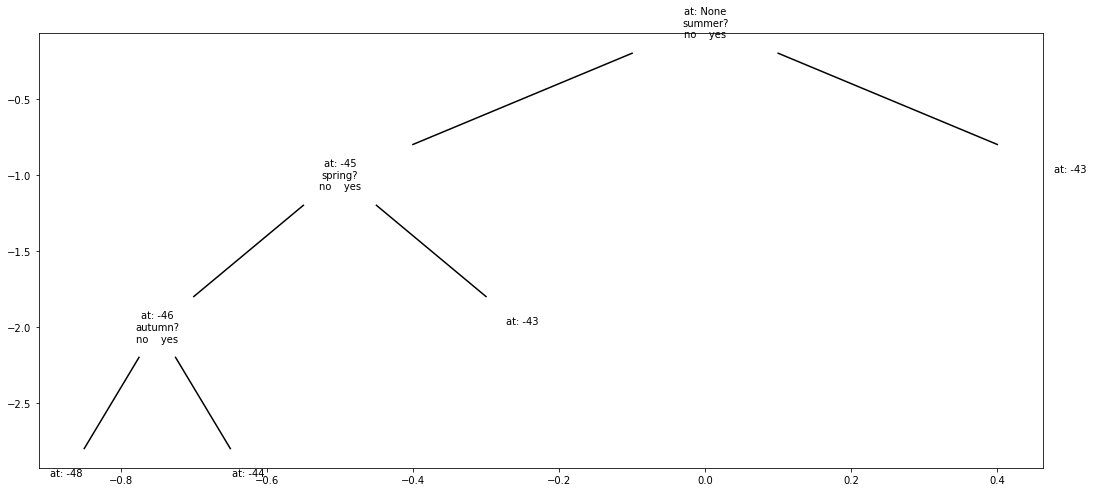

n_min 90
training nan
tuning nan


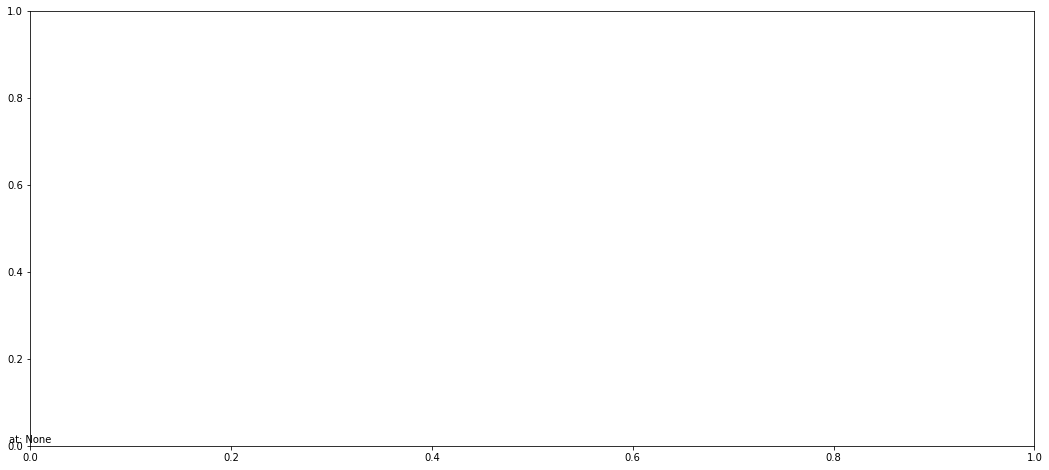

best_n_min 10
best_tuning -5.527326440177252
testing score -3.875


In [46]:
tree = create_tree(verbose=True)

In [48]:
import sys
#   Do this when the module is run as a script:
# > python3 departure_alarm.py 2018-08-25 2018-08-26 2018-12-24
if __name__ == '__main__':
    """
    Arguments
    ---------
    strings
        Each command line argument is assumed to be a date string
        of the form YYYY-MM-DD
    """
    os.environ['TZ'] = "US/Eastern"
    time.tzset()
    recommendations = recommend(sys.argv[1:], verbose=False)
    #recommendations = recommend(['2018-08-25','2018-08-26','2018-12-24'], verbose=False)
    print(recommendations)

{'2018-08-25': -40, '2018-08-26': -48, '2018-12-24': -44}
